In [2]:
from keras.layers import Input, Dense
from keras.models import Model
from sacred import Experiment

import numpy as np

autoencoder = Experiment('autoencoder', interactive=True)

encoding_dim = 32

In [14]:
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='linear', bias=False)(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='linear', bias=False)(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [16]:
import tensorflow as tf
from keras.backend import set_session

sess = tf.Session(config=tf.ConfigProto(
    inter_op_parallelism_threads=2,
    intra_op_parallelism_threads=2,
    use_per_session_threads=True))


set_session(sess)

In [17]:
autoencoder.fit(x_train, x_train,
                nb_epoch=15,
                batch_size=256,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test))

In [12]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

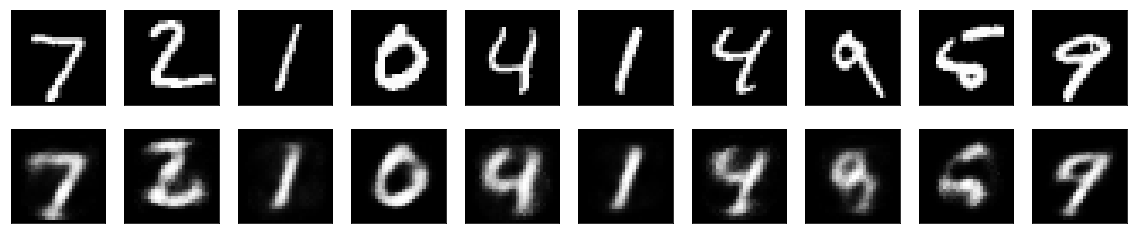

In [13]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()